In [1]:
import glob
import pandas as pd
import numpy as np
import sys
import operator
import numpy as np
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

%pylab inline
pd.options.display.max_columns = None

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# w r a n g l e + load
poi_pluto = gpd.GeoDataFrame(gpd.read_file("PLUTO/area_of_interest5.shp"))

files = glob.glob("data/*.xls")
dfs = [pd.read_excel(f, skiprows=4) for f in files]
for df in dfs:
    df.columns = ["_".join(x.strip().split(" ")) for x in df.columns]

manhattan_sales = pd.concat(dfs)
merged = manhattan_sales.merge(poi_pluto, left_on=["BLOCK", "LOT"], right_on=["Block", "Lot"])
merged["SALE_MONTH"] = merged["SALE_DATE"].apply(lambda x: str(x.year) + "-" + str(x.month))
l = list(merged.columns)
l.remove("geometry")
merged = merged.drop_duplicates(subset=l)
merged = merged[merged["SALE_PRICE"] > 1]
merged["APT"] = merged["ADDRESS"].str.split(",").apply(lambda x: x[1].strip() if len(x) > 1 else "")
def dude(x):
    return x["APARTMENT_NUMBER"].strip() if x["APARTMENT_NUMBER"].strip() else x["APT"]

merged["APARTMENT_NUMBER"] = merged["APARTMENT_NUMBER"].astype(str)
merged["APT_2"] = merged[["APT", "APARTMENT_NUMBER"]].apply(dude, axis=1)
merged["APT"] = merged["APT_2"]
merged = merged[merged["YearBuilt"] > 0].reset_index(drop=True)
df = merged

df["address_apt"] = df["Address"].apply(lambda x: x.strip() + " # ") + df["APT"]
# filter out things that arent apartments
df = df[df["APT"] != ''].reset_index(drop=True)
df["log_price"] = np.log(df["SALE_PRICE"])
df = df[df["log_price"] > 5].reset_index(drop=True) # 100k

### Regressions with basic variables

0.173818246509
0.286110646199
-0.00171153302708
-0.00537051132214


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     57.65
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           9.54e-29
Time:                        10:32:52   Log-Likelihood:                -111.98
No. Observations:                 146   AIC:                             234.0
Df Residuals:                     141   BIC:                             248.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.7346      0.094    135.767      0.000      12.549      12.920
treatment            -0.0613      0.189     -0.323      0.747      -0.436       0.313
after                 0.1607      0.094      1.715      0.089      -0.025       0.346
treatment_x_after    -0.0054      0.267     -0.020      0.984      -0.533       0.522
bedrooms              0.6734      0.045     14.902      0.000       0.584       0.763
==============================================================================
Omnibus:                       38.055   Durbin-Watson:                   0.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.940
Skew:                           1.006   Prob(JB):                     1.63e-23
Kurtosis:                       6.634   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

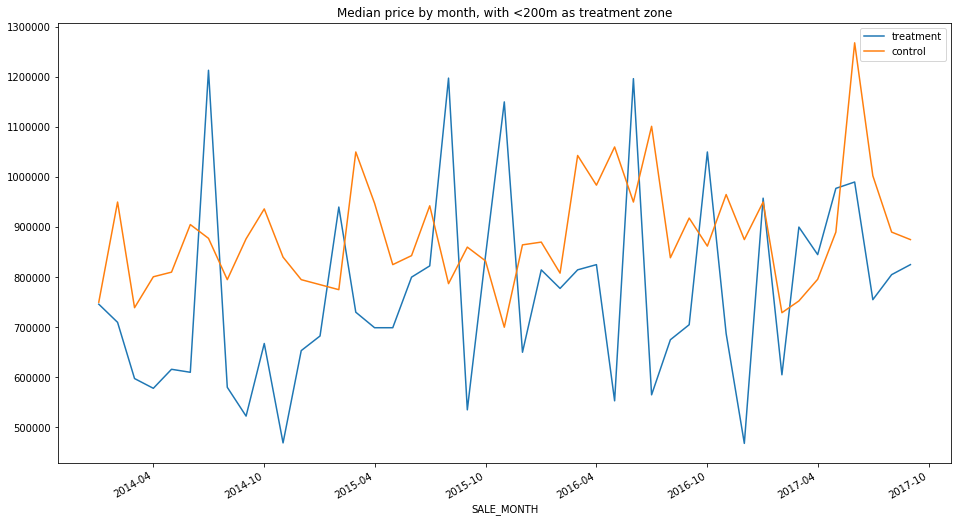

In [103]:
from datetime import datetime
cutoff = datetime(2017, 1, 1)

# make our features

# treatment and before / after
df["treatment"] = (df["distance"] < 200).astype(np.int)
df["after"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["treatment_x_after"] = df["treatment"] * df["after"]


df["prewar"] = (df["YearBuilt"] < 1950).astype(np.int)
df["postwar"] = (df["YearBuilt"] >= 1950).astype(np.int)
df["new"] = (df["YearBuilt"] >= 2000).astype(np.int)
year_cols = "prewar + postwar + new"

two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)

import bedrooms as br
reload(br)
with_br = only_before_after.merge(br.br, left_on="address_apt", right_on='addy')

import statsmodels.formula.api as smf


basic_formula = "log_price ~ treatment + after + treatment_x_after"
reg_all = smf.ols(basic_formula, data=df).fit()
reg_two = smf.ols(basic_formula, data=two_or_more_sales).fit()
reg_only = smf.ols(basic_formula, data=only_before_after).fit()
reg_br = smf.ols(basic_formula + " + bedrooms", data=with_br).fit()

print reg_all.params['treatment_x_after']
print reg_two.params['treatment_x_after']
print reg_only.params['treatment_x_after']
print reg_br.params['treatment_x_after']

fig = plt.figure(figsize=(16, 9))

median_treatment = df[df["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_control = df[df["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_treatment.index = median_treatment.index.map(lambda x: pd.to_datetime(x))
median_control.index = median_control.index.map(lambda x: pd.to_datetime(x))

ax = median_treatment.plot(figsize=(16, 9), label="treatment")
median_control.plot(ax=ax, label="control")
ax.legend()
ax.set_title("Median price by month, with <200m as treatment zone")
reg_br.summary()

### Regressions with east of second avenue

0.100203234312
0.298240755224
0.149469206908
0.145568546267


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     62.63
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           2.48e-30
Time:                        10:33:46   Log-Likelihood:                -108.17
No. Observations:                 146   AIC:                             226.3
Df Residuals:                     141   BIC:                             241.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.8767      0.104    123.631      0.000      12.671      13.083
treatment            -0.3148      0.127     -2.484      0.014      -0.565      -0.064
after                 0.1062      0.108      0.986      0.326      -0.107       0.319
treatment_x_after     0.1456      0.177      0.822      0.412      -0.205       0.496
bedrooms              0.6501      0.045     14.522      0.000       0.562       0.739
==============================================================================
Omnibus:                       34.172   Durbin-Watson:                   0.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.716
Skew:                           0.948   Prob(JB):                     1.09e-18
Kurtosis:                       6.163   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

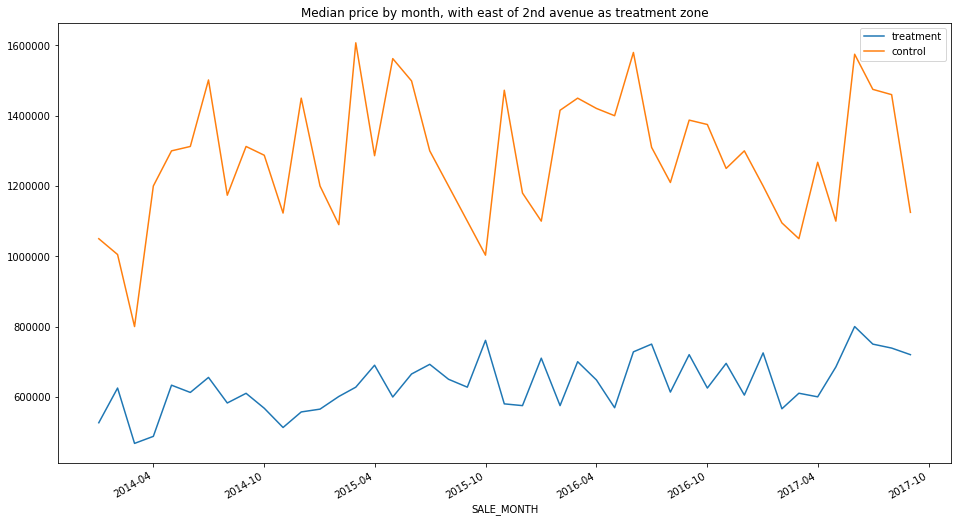

In [107]:
from datetime import datetime
cutoff = datetime(2017, 1, 1)

# make our features

# treatment and before / after
df["treatment"] = df["east_or__1"]
df["after"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["treatment_x_after"] = df["treatment"] * df["after"]


df["prewar"] = (df["YearBuilt"] < 1950).astype(np.int)
df["postwar"] = (df["YearBuilt"] >= 1950).astype(np.int)
df["new"] = (df["YearBuilt"] >= 2000).astype(np.int)
year_cols = "prewar + postwar + new"

two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)

import bedrooms as br
reload(br)
with_br = only_before_after.merge(br.br, left_on="address_apt", right_on='addy')

import statsmodels.formula.api as smf


basic_formula = "log_price ~ treatment + after + treatment_x_after"
reg_all = smf.ols(basic_formula, data=df).fit()
reg_two = smf.ols(basic_formula, data=two_or_more_sales).fit()
reg_only = smf.ols(basic_formula, data=only_before_after).fit()
reg_br = smf.ols(basic_formula + " + bedrooms", data=with_br).fit()

print reg_all.params['treatment_x_after']
print reg_two.params['treatment_x_after']
print reg_only.params['treatment_x_after']
print reg_br.params['treatment_x_after']

fig = plt.figure(figsize=(16, 9))

median_treatment = df[df["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_control = df[df["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_treatment.index = median_treatment.index.map(lambda x: pd.to_datetime(x))
median_control.index = median_control.index.map(lambda x: pd.to_datetime(x))

ax = median_treatment.plot(figsize=(16, 9), label="treatment")
median_control.plot(ax=ax, label="control")
ax.legend()
ax.set_title("Median price by month, with east of 2nd avenue as treatment zone")
reg_br.summary()

## Check out some anticipation effects

In [77]:
from datetime import datetime, timedelta
opening = datetime(2017, 1, 1)
anti_6mo = opening - timedelta(days=182)
print anti_6mo
anti_1yr = opening - timedelta(days=365)
# make our features

# treatment and before / after
df["treatment"] = df["east_or__1"]
df["after_op"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["at_6mo"] = (df["SALE_DATE"] >= anti_6mo).astype(np.int)
df["at_1yr"] = (df["SALE_DATE"] >= anti_1yr).astype(np.int)

df["treatment_x_after_op"] = df["treatment"] * df["after"]
df["treatment_x_after_6mo"] = df["treatment"] * df["at_6mo"]
df["treatment_x_after_1yr"] = df["treatment"] * df["at_1yr"]

year_cols = "prewar + postwar + new"

two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)

import bedrooms as br
reload(br)
with_br = only_before_after.merge(br.br, left_on="address_apt", right_on='addy')

import statsmodels.formula.api as smf


basic_formula = "log_price ~ treatment"
formula_6mo = basic_formula + " + at_6mo + treatment_x_after_6mo"
formula_1yr = basic_formula + " + at_1yr + treatment_x_after_1yr"
formula_6mo_time_of = formula_6mo + " + after_op + treatment_x_after_op"
reg_br_6mo_only = smf.ols(formula_6mo + " + bedrooms", data=with_br).fit()
reg_br_1yr_only = smf.ols(formula_1yr + " + bedrooms", data=with_br).fit()
reg_br_6mo_1yr = smf.ols(formula_6mo_time_of + " + bedrooms", data=with_br).fit()
fig = plt.figure(figsize=(16, 9))

median_treatment = two_or_more_sales[two_or_more_sales["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_control = two_or_more_sales[two_or_more_sales["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_treatment.index = median_treatment.index.map(lambda x: pd.to_datetime(x))
median_control.index = median_control.index.map(lambda x: pd.to_datetime(x))

2016-07-03 00:00:00


In [78]:
reg_br_1yr_only.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     60.84
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           9.00e-30
Time:                        09:48:06   Log-Likelihood:                -109.52
No. Observations:                 146   AIC:                             229.0
Df Residuals:                     141   BIC:                             244.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.8895      0.107    120.121      0.000      12.677      13.102
treatment                -0.2812      0.135     -2.084      0.039      -0.548      -0.014
at_1yr                    0.0769      0.109      0.705      0.482      -0.139       0.293
treatment_x_after_1yr     0.0679      0.180      0.378      0.706      -0.287       0.423
bedrooms                  0.6492      0.045     14.364      0.000       0.560       0.738
==============================================================================
Omnibus:                       31.843   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.017
Skew:                           0.886   Prob(JB):                     3.11e-17
Kurtosis:                       6.059   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
reg_br_6mo_only.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     62.02
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           3.84e-30
Time:                        10:22:30   Log-Likelihood:                -108.63
No. Observations:                 146   AIC:                             227.3
Df Residuals:                     141   BIC:                             242.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.8734      0.106    121.217      0.000      12.663      13.083
treatment                -0.2989      0.129     -2.310      0.022      -0.555      -0.043
at_6mo                    0.1056      0.108      0.977      0.330      -0.108       0.319
treatment_x_after_6mo     0.1092      0.178      0.615      0.540      -0.242       0.461
bedrooms                  0.6516      0.045     14.504      0.000       0.563       0.740
==============================================================================
Omnibus:                       33.467   Durbin-Watson:                   0.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.265
Skew:                           0.931   Prob(JB):                     3.72e-18
Kurtosis:                       6.118   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
reg_br_6mo_1yr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     41.42
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           1.19e-28
Time:                        09:48:14   Log-Likelihood:                -107.88
No. Observations:                 146   AIC:                             229.8
Df Residuals:                     139   BIC:                             250.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.8759      0.107    120.457      0.000      12.665      13.087
treatment                -0.2996      0.130     -2.310      0.022      -0.556      -0.043
at_6mo                    0.0358      0.530      0.067      0.946      -1.012       1.084
treatment_x_after_6mo    -0.4275      0.748     -0.571      0.569      -1.907       1.052
after_op                  0.0713      0.530      0.135      0.893      -0.976       1.119
treatment_x_after_op      0.5578      0.748      0.746      0.457      -0.921       2.036
bedrooms                  0.6501      0.045     14.305      0.000       0.560       0.740
==============================================================================
Omnibus:                       34.481   Durbin-Watson:                   0.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.494
Skew:                           0.947   Prob(JB):                     2.72e-19
Kurtosis:                       6.235   Cond. No.                         58.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Make the plot of before / after prices at distance x distance

(500000, 1000000)

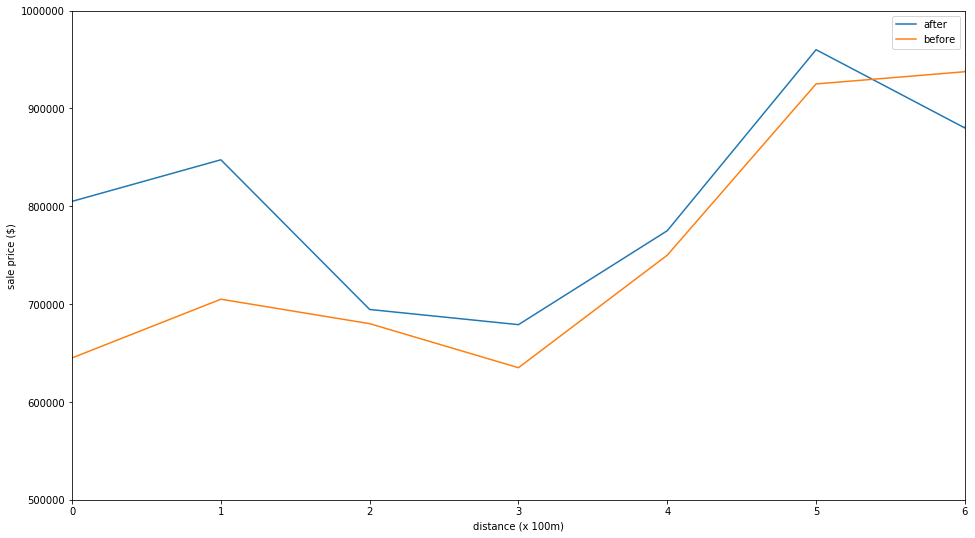

In [95]:
df["distance_100"] = (df["distance"] / 100).astype(np.int)
ax = df[df["after_op"] == 1].groupby("distance_100").median()["SALE_PRICE"].plot(label="after", figsize=(16, 9))
ax = df[df["after_op"] == 0].groupby("distance_100").median()["SALE_PRICE"].plot(ax=ax, label="before")
ax.legend()
ax.set_xlabel("distance (x 100m)")
ax.set_ylabel("sale price ($)")
ax.set_xlim(0, 6)
ax.set_ylim(500000, 1000000)

## Use Log Price

It is more normal by tests.

Text(0,0.5,u'Count')

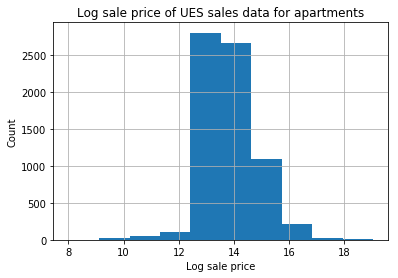

In [110]:
ax = df["log_price"].hist()
ax.set_title("Log sale price of UES sales data for apartments")
ax.set_xlabel("Log sale price")
ax.set_ylabel("Count")

### LaTeX Formatting

In [44]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,FID_1,distance,east_or__1,FID_12,distance_1,geometry,SALE_MONTH,APT,APT_2,address_apt,log_price,treatment,after,treatment_x_after,prewar,postwar,new
0,1,HARLEM-EAST,09 COOPS - WALKUP APARTMENTS,2,1624,43,,C6,"156 EAST 97TH STREET, 1",,10029,.,.,.,.,.,1930,2,C6,200000,2017-02-06,MN,1624,43,111,158.02,1000,02,5,10029,E053,23,2820,1,11,1A,156 EAST 97 STREET,R7-2,,,,,,,,,,N,C6,02,0,P,156 EAST 97TH STREET,2725,8635,0,8635,0,0,0,0,0,0,2,1,5.0,18,18,27.0,100.92,27.0,66.0,,2,N,5,2,57600.0,483300.0,57600.0,307134.0,1930,1939,2006,,,3.17,3.44,0.0,6.5,1,1.016240e+09,0,015802,998184,225631,6b,,108S045,10603,,0.0,,1,16V2,0,263.791787,2784.667103,5922,292.976495,0,5922,121.870696,"POLYGON ((998221.8100000024 225671.1615999937,...",2017-2,1,1,156 EAST 97 STREET # 1,12.206073,0,1,0,1,0,0
